# Data Quality

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("NY_Listings.csv")

C:\Users\ericl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,19,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Missing Values

First, we need to examine all missing values in the dataset. Below is a complete run-through of missing values and the techniques used to clean up the dataset.

In [2]:
len(df)

75749

75,749 rows leaves us plenty of wiggle room. Down below, you'll find a summary of null values.

In [3]:
df.isnull().sum()

Listing ID                         0
Name                              31
Host ID                            0
Host Name                        232
Host Response Rate             45118
Host Is Superhost                  0
Host total listings count        232
Street                         31439
City                               0
Neighbourhood cleansed             0
State                              0
Country                            0
latitude                           0
longitude                          0
Property type                      0
Room type                          0
Accommodates                   31439
Bathrooms                      31581
Bedrooms                       31439
Amenities                      31721
Price                              0
Minimum nights                     0
Maximum nights                 31439
Availability 365                   0
Calendar last scraped          31439
Number of reviews                  0
Last Review Date               16683
R

#### Removing unwanted columns

As you can see above, there's a concerning amount of null values. However, some of these columns are not important for our goals. These include Name, Host Name, Calendar last scraped, and Last Review Date. These columns could provide some information, but overall, I'm okay to exclude them from any work we do - especially since the text columns won't give us anything unless we do some language processing.

These columns will be entirely removed from this dataset.

In [4]:
columnsToRemove = ["Name", "Host Name", "Calendar last scraped", "Last Review Date"]

df2 = df.drop(columns = columnsToRemove, axis=1)

df2.isnull().sum()

Listing ID                         0
Host ID                            0
Host Response Rate             45118
Host Is Superhost                  0
Host total listings count        232
Street                         31439
City                               0
Neighbourhood cleansed             0
State                              0
Country                            0
latitude                           0
longitude                          0
Property type                      0
Room type                          0
Accommodates                   31439
Bathrooms                      31581
Bedrooms                       31439
Amenities                      31721
Price                              0
Minimum nights                     0
Maximum nights                 31439
Availability 365                   0
Number of reviews                  0
Review Scores Rating               0
Review Scores Accuracy             0
Review Scores Cleanliness          0
Review Scores Checkin              0
R

#### Inspecting Rows with Multiple Columns Missing

Here, we've narrowed down the nulls a good amount. Now, lets try removing the rows where Street is null. I have a suspicion that all the columns with 31,439 nulls are missing the same rows. We could try to impute these values, but I fear that columns like Accommodates and Bedrooms are too important to guess on.

In [5]:
df3 = df2[df2['Street'].notnull()]

df3.isnull().sum()

Listing ID                         0
Host ID                            0
Host Response Rate             13679
Host Is Superhost                  0
Host total listings count        232
Street                             0
City                               0
Neighbourhood cleansed             0
State                              0
Country                            0
latitude                           0
longitude                          0
Property type                      0
Room type                          0
Accommodates                       0
Bathrooms                        142
Bedrooms                           0
Amenities                        282
Price                              0
Minimum nights                     0
Maximum nights                     0
Availability 365                   0
Number of reviews                  0
Review Scores Rating               0
Review Scores Accuracy             0
Review Scores Cleanliness          0
Review Scores Checkin              0
R

In [6]:
len(df3)

44310

Above, we can see that removing Street eliminated many null values. After more investigation, we found that columns with Null Street values were actually empty rows with only zeroes and nulls. While this is simply a hypothesis, these rows may pertain to rentals that were originally listed on Airbnb by their host, but listing was abandoned before the listing was complete.

#### Last four columns
Now that we're down to just four columns to look at, I'll take them one-by-one.

##### Bathrooms

For Bathrooms, these 142 columns only represent .3% of the dataset. I think if we partition out by room type and property type, we can impute the means.

In [7]:
bathroomsIncluded = df3[df3['Bathrooms'].notnull()]
bathroomsMissing = df3[df3['Bathrooms'].isna()]

df4 = df3[["Property type", "Room type", "Bathrooms"]]
df4 = df4[(df4["Property type"].isin(bathroomsMissing["Property type"].unique()))]
df4.groupby(by=["Property type", "Room type"]).mean()

Bathrooms
Property type   Room type                 
Apartment       Entire home/apt   1.099828
                Private room      1.096143
                Shared room       1.082711
Bed & Breakfast Entire home/apt   1.187500
                Private room      1.182692
                Shared room       1.000000
House           Entire home/apt   1.646916
                Private room      1.195214
                Shared room       1.692708

In [8]:
# For these values, I feel comfortable assigning 1 to all groups except for House:Entire and House:Shared.
# Those two groups will have 2 imputed.

bathroomsOne = bathroomsMissing[(bathroomsMissing['Property type'].isin(['Apartment', 'Bed & Breakfast'])) | 
                                (bathroomsMissing['Property type'] == 'House') &
                                (bathroomsMissing['Room type'] == 'Private room')]

bathroomsTwo = bathroomsMissing[(bathroomsMissing['Property type'] == 'House') &
                               (bathroomsMissing['Room type'] != 'Private room')]


bathroomsOne.loc[:, "Bathrooms"] = 1
bathroomsTwo.loc[:, "Bathrooms"] = 2

df5 = pd.concat([bathroomsIncluded, bathroomsOne, bathroomsTwo], ignore_index=True, axis=0)

#df5.isnull().sum()

C:\Users\ericl\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


##### Amenities

Since this column is formatted as a list of values, there isn't an easy process to impute these values. Since this is only .05% of the data, we will just remove these rows.

In [9]:
df6 = df5[df5['Amenities'].notnull()]
#df6.isnull().sum()

#### Host Response Rate

I think this column is fairly important to predicting rating / price. Therefore, we can't just remove these rows. First, we can check for an overlap of hosts with included and missing values. For those that don't match - we will just impute the median.

In [10]:
responseIncluded = df6[df6['Host Response Rate'].notnull()]
responseMissing = df6[df6['Host Response Rate'].isna()]

responseIncluded_small = responseIncluded[["Host ID", "Host Response Rate"]]
responseMissing_small = responseMissing[["Host ID", "Host Response Rate"]]

responseMatches = pd.merge(left = responseIncluded_small, right = responseMissing_small, on="Host ID", how="inner")

responseMatches

,Host ID,Host Response Rate_x,Host Response Rate_y


In [11]:
responseMissing.loc[:, "Host Response Rate"] = responseIncluded["Host Response Rate"].median()

df7 = pd.concat([responseIncluded, responseMissing], ignore_index=True, axis=0)

#df7.isnull().sum()

C:\Users\ericl\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### Host total listings count

We will handle this column the same way we handled Host Response Rate. Check for matches and impute the mean for those that do not match.

In [12]:
listingsIncluded = df7[df7['Host total listings count'].notnull()]
listingsMissing = df7[df7['Host total listings count'].isna()]

listingsIncluded_small = listingsIncluded[["Host ID", "Host total listings count"]]
listingsMissing_small = listingsMissing[["Host ID", "Host total listings count"]]

listingsMatches = pd.merge(left = listingsIncluded_small, right = listingsMissing_small, on="Host ID", how="inner")

listingsMatches

,Host ID,Host total listings count_x,Host total listings count_y


In [13]:
listingsMissing.loc[:, "Host total listings count"] = listingsIncluded["Host total listings count"].median()

df8 = pd.concat([listingsIncluded, listingsMissing], ignore_index=True, axis=0)

#df8.isnull().sum()

C:\Users\ericl\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
print("Number of rows: ", str(len(df8)))
df8.isnull().sum()

Number of rows:  44028


Listing ID                     0
Host ID                        0
Host Response Rate             0
Host Is Superhost              0
Host total listings count      0
Street                         0
City                           0
Neighbourhood cleansed         0
State                          0
Country                        0
latitude                       0
longitude                      0
Property type                  0
Room type                      0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Amenities                      0
Price                          0
Minimum nights                 0
Maximum nights                 0
Availability 365               0
Number of reviews              0
Review Scores Rating           0
Review Scores Accuracy         0
Review Scores Cleanliness      0
Review Scores Checkin          0
Review Scores Communication    0
Review Scores Location         0
Review Scores Value            0
Reviews pe

#### Finalizing Null Values

The output above shows that the dataset has no null values anymore and remains at 44,028 rows.

### Outlier Values

To detect outliers, we need to slim down our dataset to columns which would logically have outliers (numerical columns that are not IDs). Then, we need to classify those columns as normal or skewed.

array([[<AxesSubplot:title={'center':'Host Response Rate'}>,
        <AxesSubplot:title={'center':'Host total listings count'}>,
        <AxesSubplot:title={'center':'Accommodates'}>,
        <AxesSubplot:title={'center':'Bathrooms'}>],
       [<AxesSubplot:title={'center':'Bedrooms'}>,
        <AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Minimum nights'}>,
        <AxesSubplot:title={'center':'Maximum nights'}>],
       [<AxesSubplot:title={'center':'Availability 365'}>,
        <AxesSubplot:title={'center':'Number of reviews'}>,
        <AxesSubplot:title={'center':'Review Scores Rating'}>,
        <AxesSubplot:title={'center':'Review Scores Accuracy'}>],
       [<AxesSubplot:title={'center':'Review Scores Cleanliness'}>,
        <AxesSubplot:title={'center':'Review Scores Checkin'}>,
        <AxesSubplot:title={'center':'Review Scores Communication'}>,
        <AxesSubplot:title={'center':'Review Scores Location'}>],
       [<AxesSubplot:title={'cent

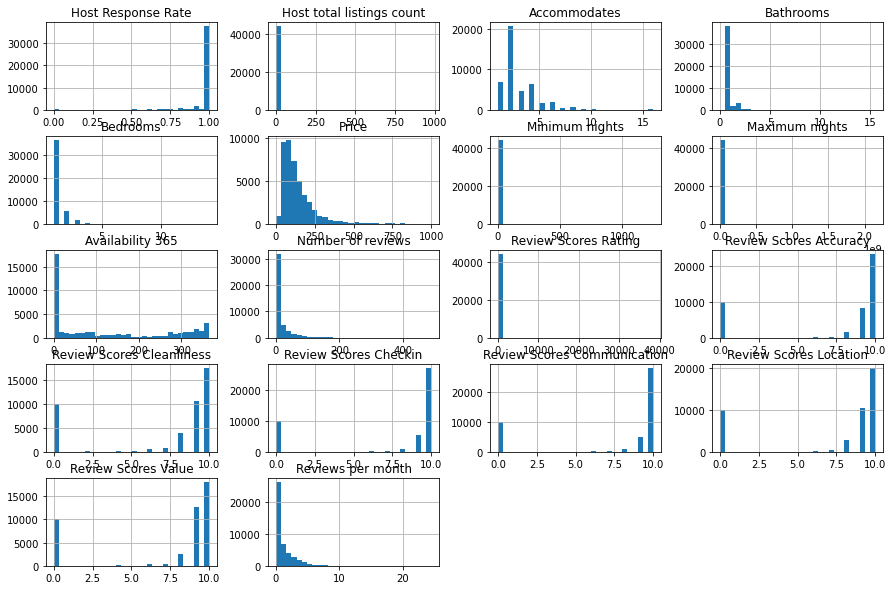

In [15]:
outlier_df = df8[['Host Response Rate','Host total listings count','Accommodates','Bathrooms', 'Bedrooms', 'Price',
            'Minimum nights', 'Maximum nights','Availability 365', 'Number of reviews', 'Review Scores Rating',
            'Review Scores Accuracy', 'Review Scores Cleanliness','Review Scores Checkin', 'Review Scores Communication',
            'Review Scores Location', 'Review Scores Value', 'Reviews per month']]

outlier_df.hist(bins=30, figsize=(15, 10))

Looking at the above histograms, we can classify all columns as skewed. Therefore, we will now classify outliers as values outside the range (Q1 - 1.5 * IQR) , (Q3 + 1.5 * IQR).

In [16]:
lower_bounds = []
upper_bounds = []
maximums = []
columns = outlier_df.columns
outlier_count = []

for col in outlier_df.columns:
    Q3 = np.quantile(outlier_df[col], 0.75)
    Q1 = np.quantile(outlier_df[col], 0.25)
    Max = max(outlier_df[col])
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    
    if lower_range < 0:
        lower_range = 0
    
    upper_range = Q3 + 1.5 * IQR
    
    outliers = len(outlier_df[(outlier_df[col] > upper_range) | (outlier_df[col] < lower_range)])
    
    lower_bounds.append(lower_range)
    upper_bounds.append(upper_range)
    maximums.append(Max)
    outlier_count.append(outliers)
    
bounds_df = pd.DataFrame(list(zip(columns, lower_bounds, upper_bounds, maximums, outlier_count)), 
                         columns = ["Column","Lower","Upper", "Maximum", "Outlier Count"])

pd.options.display.float_format = '{:.5f}'.format

bounds_df

,Column,Lower,Upper,Maximum,Outlier Count
0,Host Response Rate,1.00000,1.00000,1.00000,7008
1,Host total listings count,0.00000,3.50000,979.00000,3964
2,Accommodates,0.00000,7.00000,16.00000,1285
3,Bathrooms,1.00000,1.00000,15.50000,6121
4,Bedrooms,1.00000,1.00000,14.00000,7849
5,Price,0.00000,326.50000,999.00000,2279
6,Minimum nights,0.00000,8.50000,1250.00000,2875
7,Maximum nights,0.00000,2769.00000,2147483647.00000,65
8,Availability 365,0.00000,695.00000,365.00000,0
9,Number of reviews,0.00000,48.50000,489.00000,5011


#### Column-Specific Outlier Handling

Now we have the lower and upper bounds of our outlier ranges. However, some columns might have outliers - but they're valid data points. Let's take them one by one.

Accommodates: A maximum of 16 is certainly understandale and could very realistically be true. Although some of these rentals that claim to accommodate 16 people are oddly small, that value of 16 still isn't outlandish. Therefore, we'll keep those in.

Bathrooms: Although the maximum of 15.5 is large, that Airbnb has 14 bedrooms. Therefore, it is likely this is just a very large rental.

Bedrooms: The rental with 14 bathrooms is the same one discussed immediately above. Therefore, this value checks out.

Price: Logically, a maximum of $999 makes sense. And since we don't quite have a way to validate or invalidate these prices, we will leave them in.

Minimum nights: The ~3000 rows with a minimum nights value over 8.5 is quite daunting. It is likely that some of the higher values (above 50) are mistakes, as Airbnbs with a minimum night stay of 50 nights is unheard of. Therefore, we will cap the maximum value for this column at 10.

Maximum nights: Similar to minimum nights, it is very likely that these higher values are mistakes. Since Airbnbs do allow very long stays, we will cap the maximum at 365.

Availability 365: The logical maximum for this column is 365. This is the maximum for this column, so these values are valid.

Number of reviews: The upper bound here of ~50 reviews is fairly low. In fact, the maximum of 489 reviews isn't outlandish either. Therefore, we can't classify any of these values as mistakes, so these values will remain.

Review Scores Accuracy - Review Scores Value: The maximum here (according to the data dictionary) is 10. Therefore, these columns are valid.

Reviews per month: While the maximum of 24.53 is impressive, it cannot be ruled out. Therefore, we will keep those values.

In [17]:
# Host Response Rate

# The logical maximum for this value is 1. However, the "outlier" values are actually 1.0, as seen below.
# Therefore, there are no valid outliers in this column.

temp_df = df8[df8['Host Response Rate'] >= 1]

temp_df['Host Response Rate'].value_counts()

1.00000    37020
Name: Host Response Rate, dtype: int64

In [18]:
# Host total listings count

# Here, we can see that there are values in the 100's. However, we do not know if some of these listings being counted are
# owned by this host in other areas. Therefore, this column is difficult to separate into outlier status.

temp_df = df8[df8['Host total listings count'] > 3.50000]

temp_df['Host total listings count'].unique()

array([  4.,  16.,   5.,   6.,  14.,  12.,   8.,   7., 149.,  15.,  10.,
         9.,  11.,  22.,  47.,  13.,  28.,  17.,  23.,  19.,  20.,  31.,
       296., 236.,  24.,  33.,  64., 113.,  39.,  54.,  42.,  94., 218.,
        27., 648.,  18.,  38.,  56.,  49., 316., 979.,  35., 248.,  25.,
       258.,  36.,  21.,  83.,  52., 159.,  85.,  41.])

In [19]:
# Review Scores Rating

# The maximum here (according to the data dictionary) is 100. Those that are above this threshold are wildy so, having
# three occurrences of 38,425. These are likely mistakes, so these rows will be removed.

temp_df = df8[df8['Review Scores Rating'] > 100]

temp_df['Review Scores Rating'].value_counts()

38425    3
Name: Review Scores Rating, dtype: int64

From the research above, we came away with a few transformations to make:
    1. Cap minimum nights at 10.
    2. Cap maximum nights at 365.
    3. Remove three rows with review scores rating above 100

In [20]:
df8.clip(upper=pd.Series({'Minimum nights': 10, 'Maximum nights': 365}), axis=1)
print(df8.shape)
df9 = df8[df8['Review Scores Rating'] <= 100]
print(df9.shape)

(44028, 31)
(44025, 31)


### Duplicate Values

Almost all of the columns in this dataset would logically have duplicate values. The only column that should not have any duplicate values is Listing ID. Therefore, we will compare the length of the dataset with the amount of unique Listing IDs.

In [21]:
print("Number of observations: ", str(len(df9)))
print("Number of unique Listing ID's: ", str(len(df9['Listing ID'].unique())))

Number of observations:  44025
Number of unique Listing ID's:  44025


In [22]:
df9.to_csv(r"C:\Users\ericl\OneDrive\Desktop\SMU\NY_Listings_Validated.csv")